In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [4]:
# videoPath = 'data/camera_intrinsic_calib.mp4'
videoPath = '/home/garamizo/Software/xmas-lights/data/ribeiro2022_base4/calib.mp4'
imagesPath = '/home/garamizo/Software/xmas-lights/data/camera_intrinsic_calib'

os.system('rm -rf %s ; mkdir -p %s' % (imagesPath, imagesPath))

cap = cv2.VideoCapture(videoPath)
fps = cap.get(cv2.CAP_PROP_FPS)
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

frameNum = 0
while cap.isOpened() and frameNum < totalFrames - 2*fps:
    frameNum = cap.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = cap.read()
    
    if ret and (round(frameNum + 2*fps) % round(1.0 * fps)) == 0:
                   
        cv2.imwrite('%s/img%04d.jpg' % (imagesPath, round(frameNum)), frame)
        print(".", end="")

.....................................................

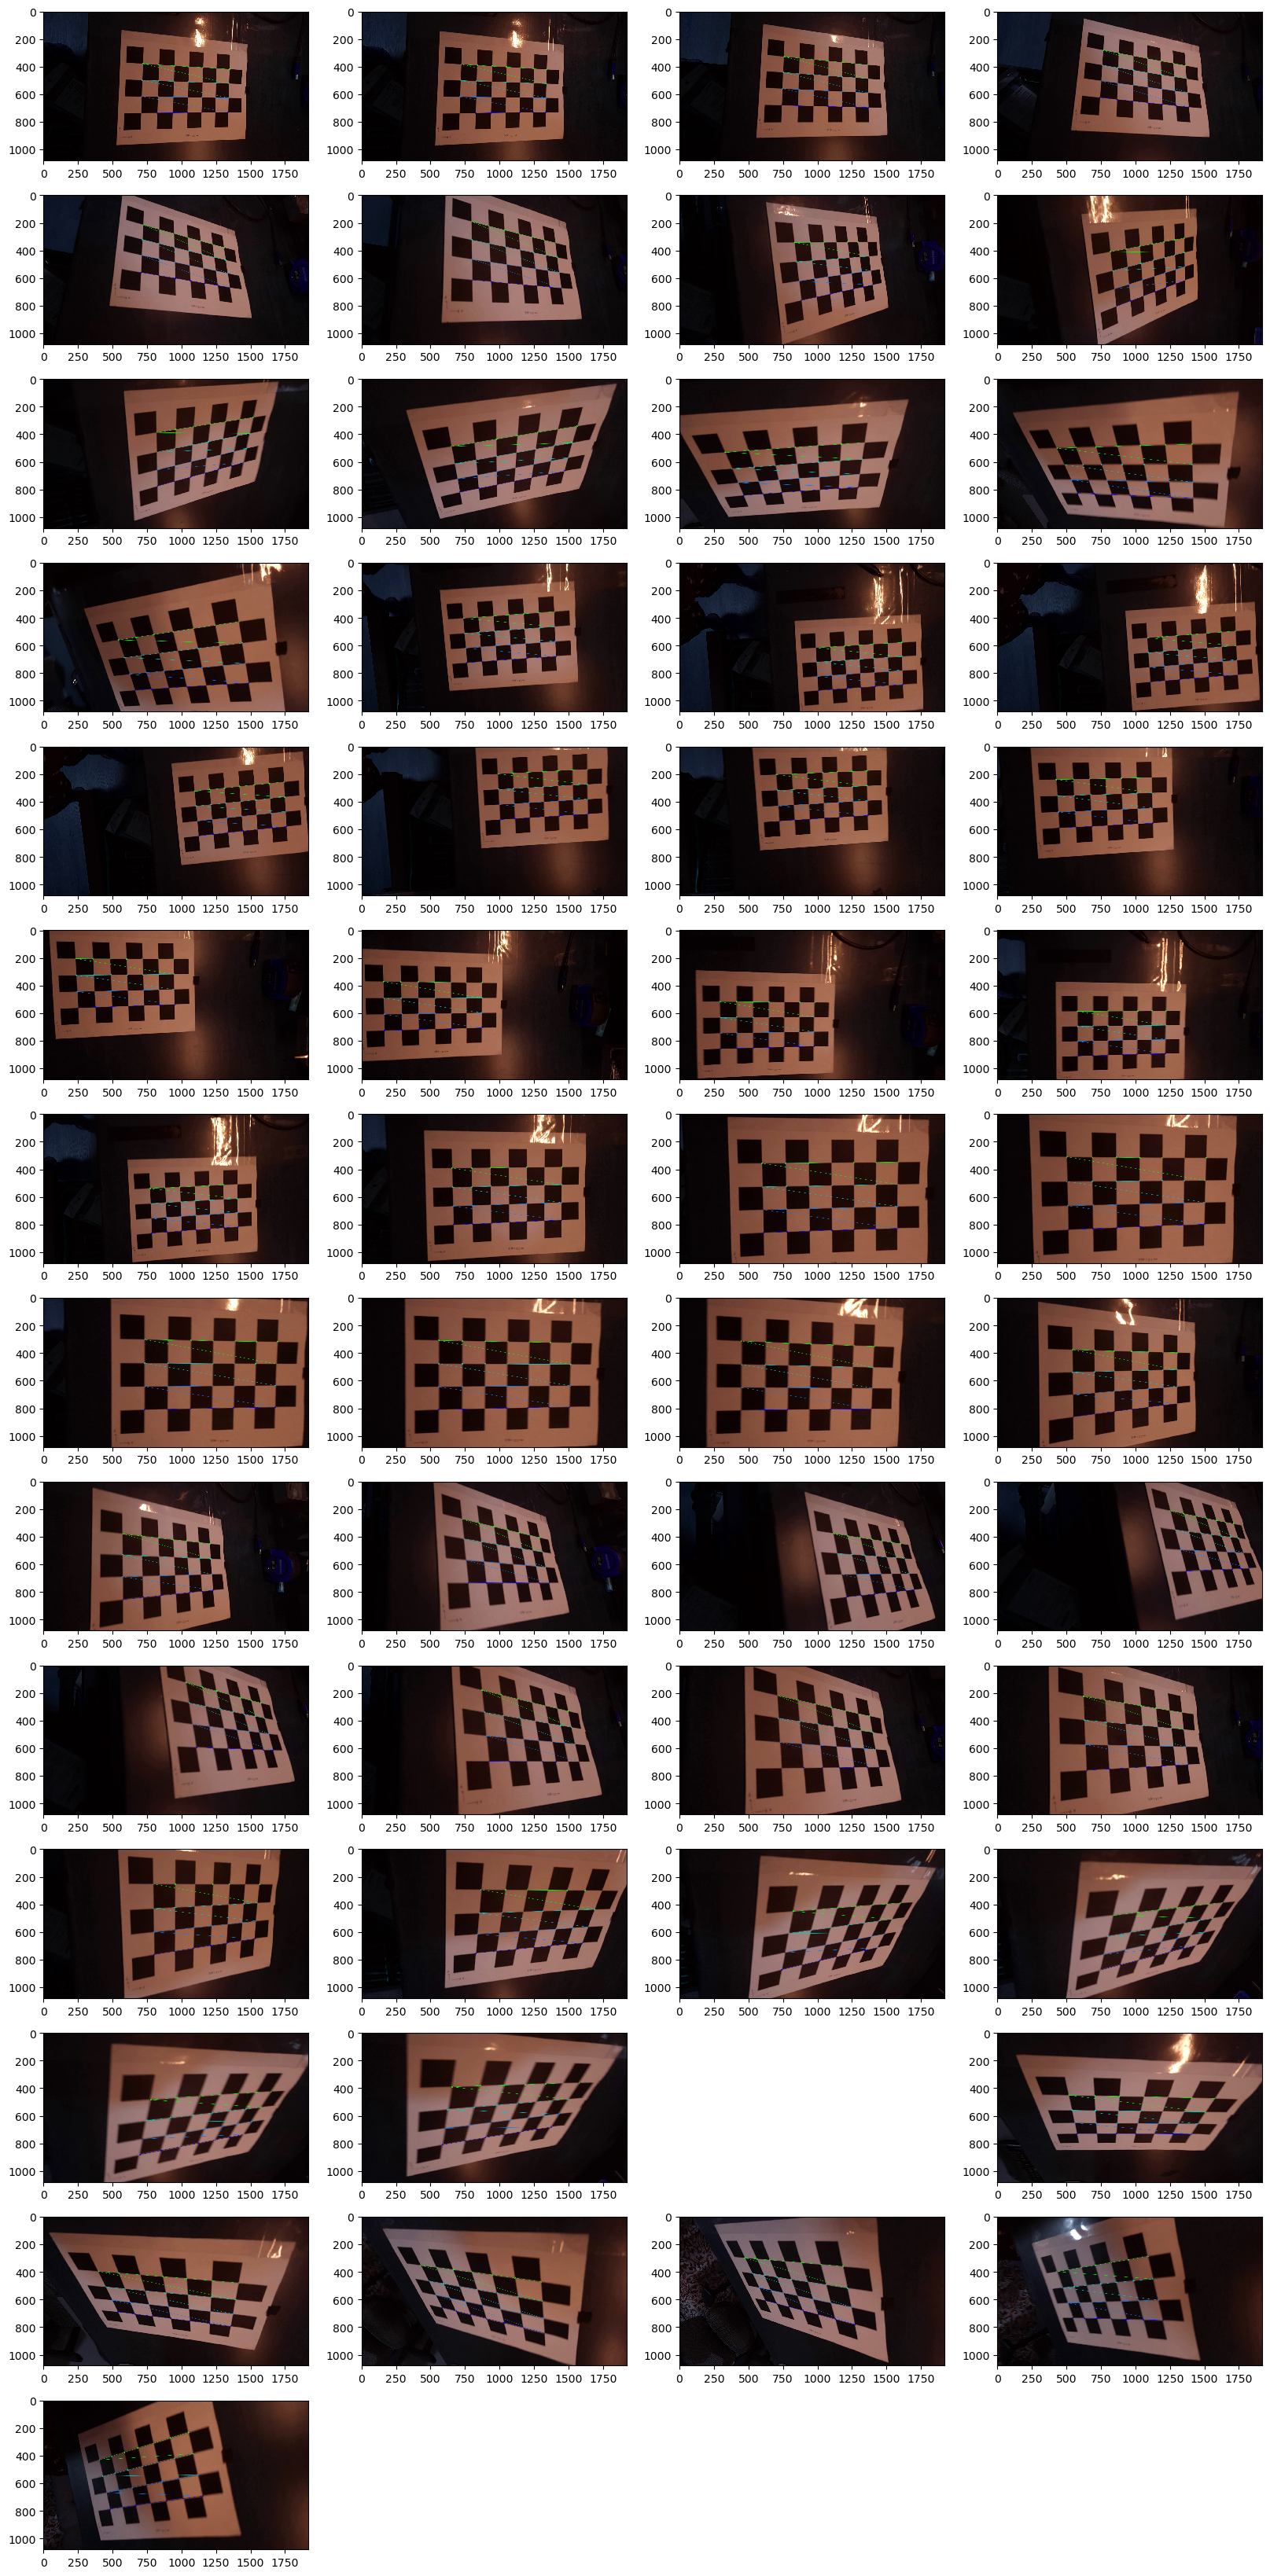

In [7]:
nx = 7
ny = 4

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
imgfile = []

# images = glob.glob('*.jpg')
images = sorted(glob.glob('%s/img*.jpg' % imagesPath))

num_cols_plot = 4.0
plt.figure(figsize=(20, np.ceil(len(images)/num_cols_plot) * 3))

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        imgfile.append(fname)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners2,ret)

        plt.subplot(np.ceil(len(images)/num_cols_plot), num_cols_plot, i+1)
        plt.imshow(img.transpose([1,0,2]))
        plt.draw
        # cv2.waitKey(500)

# cv2.destroyAllWindows()

In [23]:
import pickle
from calibrate import calibrate_fisheye

img_size = (img.shape[1],img.shape[0])

imageList = sorted(glob.glob(imagesPath + '/img*.jpg'))
dist_pickle = calibrate_fisheye(imageList, (nx,ny))

# Do camera calibration given object points and image points
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# print("Saving the parameter to file...>>camera_cal.p")
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# dist_pickle["dist"] = D
# dist_pickle["ret"] = ret
# dist_pickle["rvecs"] = rvecs
# dist_pickle["tvecs"] = tvecs
# dist_pickle["objpoints"] = objpoints
# dist_pickle["imgpoints"] = imgpoints
# dist_pickle["imgfile"] = imgfile
# dist_pickle["img_size"] = img_size

pickle_file = open("samsung_intrinsics_fisheye.p", "wb")
pickle.dump(dist_pickle, pickle_file)
pickle_file.close() 

Found 52 valid images for calibration
DIM=(1080, 1920)
K=np.array([[1463.103002313097, 0.0, 521.5735157916682], [0.0, 1468.9377396514667, 967.8413557953457], [0.0, 0.0, 1.0]])
D=np.array([[0.040933087131256755, -0.007452500753345227, 0.0055539984337616075, 0.0015819987764848333, -0.039399031227480466]])
rms=1.2629095953688843


/tmp/ipykernel_3610/225189047.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


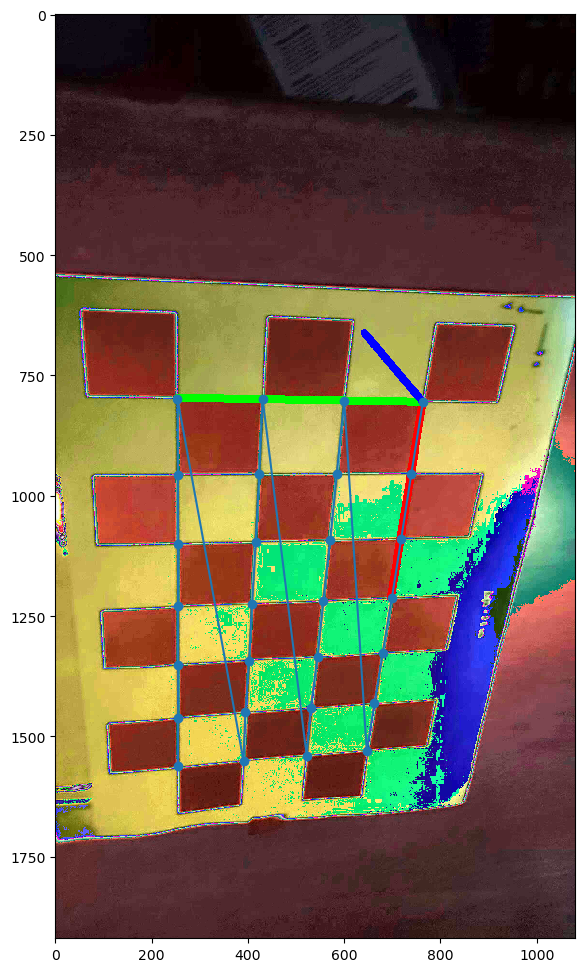

In [19]:
%matplotlib inline

def draw_axis(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype(np.int32))
    img = cv2.line(img, corner, tuple(imgpts[0].ravel().astype(np.int32)), (255,0,0), 15)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel().astype(np.int32)), (0,255,0), 15)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel().astype(np.int32)), (0,0,255), 15)
    return img

calib = pickle.load(open("samsung_intrinsics_fisheye.p", "rb"))

num = 40

imgp = calib["imgpoints"][num]
objp = calib["objpoints"][num]    
imgfile = calib["imgfile"][num]
rvecs = calib["rvecs"][num]
tvecs = calib["tvecs"][num]
mtx = calib["mtx"]
dist = calib["dist"]

# axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)
axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,1,3)
imgpts, jac = cv2.fisheye.projectPoints(axis, rvecs, tvecs, mtx, dist)
img = cv2.imread(imgfile)
img = draw_axis(img * 5, imgp, imgpts)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img)
ax.plot(imgp[:,:,0].flatten(), imgp[:,:,1].flatten(), 'o-', )
fig.show()

In [13]:
imgpts.tolist()

[[[697.8746337890625, 1213.153076171875]],
 [[254.00270080566406, 797.497314453125]],
 [[642.64404296875, 662.3788452148438]]]

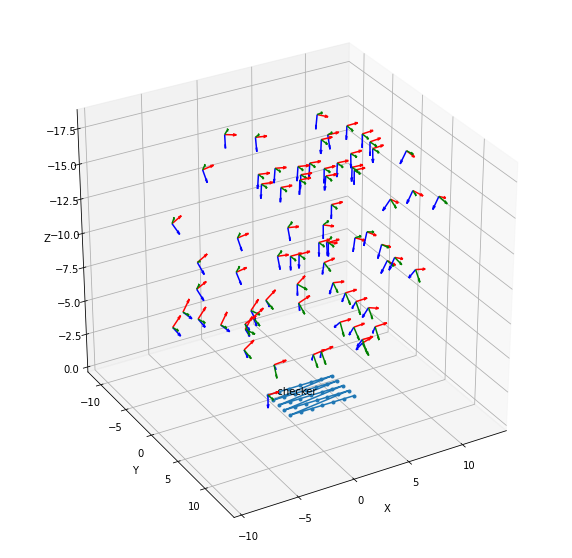

In [62]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_frame(ax, trans, R, name, length=1):
    trans = trans.reshape(-1)
    ax.quiver(trans[0], trans[1], trans[2], R[0,0], R[1,0], R[2,0], color='r', length=length)
    ax.quiver(trans[0], trans[1], trans[2], R[0,1], R[1,1], R[2,1], color='g', length=length)
    ax.quiver(trans[0], trans[1], trans[2], R[0,2], R[1,2], R[2,2], color='b', length=length)
    ax.text(trans[0], trans[1], trans[2], str("   ")+name, color='black')

squareSize = 1
corners = objp.reshape(-1, 3) * squareSize

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

plot_frame(ax, np.array([[0],[0],[0]]), np.eye(3), "checker")
ax.plot(corners[:,0], corners[:,1], corners[:,2], '.-')

# ax.axis('equal')
# ax.set_aspect('equal')
# ax.set(xlim=(-0.3,0.3), ylim=(-0.3,0.3), zlim=(-0.4,0.2))
ax.view_init(210,-60)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for tvec, rvec in zip(calib["tvecs"], calib["rvecs"]):
    Rvec, _ = cv2.Rodrigues(rvec)
    R = Rvec.T
    tvec = -Rvec.T.dot(tvec * squareSize)

    plot_frame(ax, tvec, R, "", 1)

plt.show()